In [7]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

# relevant distributions
T = scipy.stats.t
Binomial = scipy.stats.binom

# get data
data = pd.read_csv("/Users/IKleisle/Downloads/runtimes.csv")
data.columns = [item.replace(".", "_") for item in data.columns]

# add on group-specific means
data = pd.merge(
    data,
    data.groupby(["alg_name", "prob_ind"], as_index=False)["runtime"].mean(),
    on=["alg_name", "prob_ind"],
    suffixes=["", "_bar"]
)

# total rows
N = data.shape[0]
M = len(data.alg_name.unique())
P = len(data.prob_ind.unique())
N_ = data.query("alg_name == 'A' & prob_ind == 1").shape[0]
# make sure dims all good
assert N_ * P * M == N
# precompute S2
S2 = (1 / (N - M * P)) * np.sum(
    (data["runtime"].values - data["runtime_bar"].values) ** 2
)

# just so I know what's in data
print(f"""Unique Algorithms: {data.alg_name.unique()}
Unique Problems: {data.prob_ind.unique()}""")

data.head()

Unique Algorithms: ['A' 'B' 'C' 'D' 'E']
Unique Problems: [1 2 3 4 5 6]


,alg_name,prob_ind,runtime,runtime_bar
0,A,1,2.334859,4.868379
1,A,1,1.400394,4.868379
2,A,1,3.621056,4.868379
3,A,1,3.009073,4.868379
4,A,1,2.003461,4.868379


### Part 1: T-Tests

In [8]:
def perform_t_test(model, ref_model="A"):
    """"""
    data_ref = data.query(f"alg_name == '{ref_model}'")
    data_mod = data.query(f"alg_name == '{model}'")

    y_bar_ref = data_ref.runtime.values.mean()
    y_bar_mod = data_mod.runtime.values.mean()

    assert N_ * P == data_ref.shape[0]
    assert N_ * P == data_mod.shape[0]

    t_stat = np.sqrt(N_ * P / 2) * (y_bar_mod - y_bar_ref) / np.sqrt(S2)
    pval = T(df=N - M * P).cdf(t_stat)

    return t_stat, pval

t_result = pd.DataFrame(
    [perform_t_test(i) for i in data.alg_name.unique()[1:]],
    columns=["t_statistic", "p_value"]
)
t_result["algorithm"] = data.alg_name.unique()[1:]

t_result

,t_statistic,p_value,algorithm
0,2.302933,0.989289,B
1,-0.356643,0.360705,C
2,-4.585126,0.000002,D
3,0.238915,0.594397,E


In [9]:
data.groupby(["alg_name"], as_index=False)["runtime"].mean().rename(columns={"runtime": "mean_runtime"})

,alg_name,mean_runtime
0,A,1.591834
1,B,1.845468
2,C,1.552555
3,D,1.086851
4,E,1.618147


As given by the problem's composite Hypothesis, this is a one-sided (lower) test. As shown in the results above, we see that for $\alpha = .05$ the test rejects for algorithm D, suggesting D may be superior to A. As a sanity check, this matches the groupwise averages,  wherein the average runtime for D is 1.09 and the average for A is 1.59. 

### Part 2: Bernoulli-Test

In [10]:
def perform_general_test(model, ref_model="A"):
    """"""
    data_ref = data.query(f"alg_name == '{ref_model}'")
    data_mod = data.query(f"alg_name == '{model}'")
    bjk_results = (data_ref.runtime.values <= data_mod.runtime.values).astype(int)

    pval = 1 - Binomial(N_ * P, 1/2).cdf(np.sum(bjk_results))
    return np.sum(bjk_results), pval

In [11]:
gen_result = pd.DataFrame(
    [perform_general_test(i) for i in data.alg_name.unique()[1:]],
    columns=["Sum(Bjk)", "p_value"]
)
gen_result["algorithm"] = data.alg_name.unique()[1:]

gen_result

,Sum(Bjk),p_value,algorithm
0,252,1.110223e-16,B
1,231,1.110223e-16,C
2,169,1.209099e-02,D
3,244,1.110223e-16,E


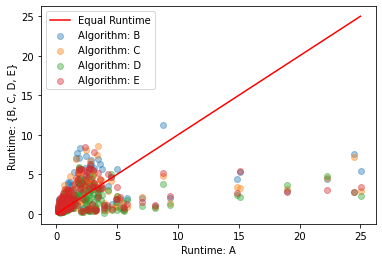

In [13]:
for mod in ["B", "C", "D", "E"]:
    plt.scatter(
        data.query("alg_name == 'A'").runtime.values,
        data.query(f"alg_name == '{mod}'").runtime.values,
        alpha=.4,
        label=f"Algorithm: {mod}"
    )
plt.plot([0, 25], [0, 25], label="Equal Runtime", color="red")
plt.legend()
plt.xlabel("Runtime: A")
plt.ylabel("Runtime: {B, C, D, E}")
plt.show()

Now, the hypothesis has been reversed, and the null is that the probability that Algorithm 1 is faster than Algorithm i is less than or equal to one-half -- this null is less believable, the more instances 1/0 in which 1 beats i occurs. As the first column in the table, as well as the scatterplot show, algorithm 1 routinely beats the others, leading to a clean sweep of rejections at $\alpha = .05$. However, as this test does not explicitly correct for the $\beta$ variables (as the proper ANOVA setup does), this result may be misleading. Hence, in light of the ANOVA results, I'm inclined to think that Algorithm D may have a leg up on algorithm A. 